In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
df = pd.read_csv('D:/FinancialPaymentFraudDetection/data/bills_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [6]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [7]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [8]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [9]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = -1

In [10]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [11]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [12]:
trainX.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2524233,205,1,23543.56,-1.0,-1.0,203469.86,227013.42,23543.56,-2.910383e-11
5811020,401,1,282633.07,-1.0,-1.0,812202.26,1094835.33,282633.07,0.000000e+00
6022467,469,1,213672.07,202.0,0.0,277383.99,491056.06,213470.07,0.000000e+00
4229297,306,1,29386.14,16357.0,0.0,0.00,29386.14,13029.14,0.000000e+00
6252505,596,1,12269.07,926.0,0.0,142269.35,154538.43,11343.07,-1.000000e-02


In [13]:
trainY.head()

2524233    0
5811020    0
6022467    0
4229297    0
6252505    0
Name: isFraud, dtype: int64

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfMod = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
                               random_state=None, verbose=0)
rfMod.fit(trainX,trainY)
rfMod.score(testX, testY)

0.99998736649088038

In [15]:
test_labels=rfMod.predict_proba(np.array(testX.values))[:,1]

In [16]:
from sklearn.metrics import roc_auc_score
roc_auc_score(testY,test_labels , average='macro', sample_weight=None)

0.99880210849742845

In [17]:
from sklearn.metrics import average_precision_score
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              test_labels)))
df_confusion_rf = metrics.confusion_matrix(testY, test_labels.round())
print(df_confusion_rf)
plot_confusion_matrix(df_confusion_rf)

AUPRC = 0.9975738174854184


NameError: name 'metrics' is not defined

In [18]:
from sklearn import tree
dcsnTree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)

In [19]:
dcsnTree.fit(trainX,trainY)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
dcsnTree.score(testX, testY)

0.99998014734281204

In [21]:
pred=dcsnTree.predict_proba(np.array(testX.values))[:,1]
roc_auc_score(testY,pred , average='macro', sample_weight=None)

0.99950688490725992

In [22]:

df_confusion = metrics.confusion_matrix(testY, pred.round())

In [23]:
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              pred)))
df_confusion

AUPRC = 0.9964451186024113


array([[552410,      2],
       [     9,   1661]], dtype=int64)

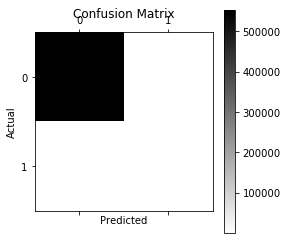

In [66]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plot_confusion_matrix(df_confusion)